# Optimization and Simulation with DR

## optunaによる単目的関数の最適化

### 1. ライブラリ類のインポートとファイルのロード

In [ ]:
%matplotlib inline

import os
import copy
import warnings

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import datarobot as dr
from datarobot_predict.deployment import predict

import optuna

import japanize_matplotlib

if not os.getenv("DATAROBOT_NOTEBOOK_IMAGE"):
    print("not running in DataRobot Notebook")
    from dotenv import load_dotenv
    load_dotenv("../.env", override=True)

client = dr.Client()

seed = 71
np.random.seed(seed)
warnings.filterwarnings("ignore")
plt.rcParams.update({"figure.max_open_warning": 0})
optuna.visualization.is_available()
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.set_option("display.precision", 8)

not running in DataRobot Notebook


In [28]:
targets = ["降伏強度", "引張強度"]

df = pd.read_csv("../data/opt_steel_strength.csv")

In [29]:
y_train1 = df["降伏強度"]
y_train2 = df["引張強度"]
X_train = df.drop(["ID", "降伏強度", "引張強度"], axis=1)

### 2. 予測APIを用いる上での必要な情報を準備しておきます。

In [ ]:
# 予測APIを叩くための諸々を設定する必要があります
dr.Client()
deployment_ids = ["67bc6ab2f1b3f6b73d560ff8", "67bc6ab999dbbff523b1152a"]
deployment_quant_ids = ["67bc6ad2fd8c6942c3561092", "67bc6ad599dbbff523b11589"]
deployments = [dr.Deployment.get(deployment_id) for deployment_id in deployment_ids]
deployments_quant = [
    dr.Deployment.get(deployment_id) for deployment_id in deployment_quant_ids
]
# 実験時間、実験回数（n_trials）での制御も可能
timeout = 15

# 結果格納用
result = []

### 3. `datarobot-predict`を使って予測APIを叩く

In [31]:
# 一回叩いてみる
predictions, _ = predict(deployments[0], X_train.iloc[:1])
predictions

,降伏強度_PREDICTION,DEPLOYMENT_APPROVAL_STATUS
0,2262.14794922,APPROVED


In [32]:
# 予測の戻り値から予測値を取り出す
predictions.loc[0, "降伏強度_PREDICTION"]

np.float64(2262.1479492188)

In [33]:
# 結果記録用のヘルパーメソッド
def update_result(result, study, sampler, pruner, n_jobs):
    dict_trial = {
        "sampler": sampler,
        "pruner": pruner,
        "n_jobs": n_jobs,
        "値": study.best_trial.value,
        "回数": len(study.trials),
        **study.best_trial.params,
    }
    result.append(dict_trial)
    print(dict_trial)
    return result

### 4. 最適化する対象設定します。この関数の戻り値が最小化されるようにoptunaが探索空間からいい感じの入力データを見つけてくれます。

In [34]:
std_1 = y_train1.std()
stat = X_train.describe().T


def objective(trial):

    df_target = DataFrame(index=[0], columns=X_train.columns)
    for col in X_train.columns:
        low = stat.loc[col, "min"] * 0.8
        high = stat.loc[col, "max"] * 1.2
        df_target[col] = trial.suggest_float(col, low, high, step=0.01)

    pred_1 = predict(deployments[0], df_target)[0].loc[0, "降伏強度_PREDICTION"]

    return pred_1

### 5. 最適化を実行する

In [35]:
%%time
dr.Client()
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=timeout, gc_after_trial=True)

[I 2025-02-24 20:43:51,861] A new study created in memory with name: no-name-faf9fed4-5704-42a9-852a-2cc0021fea94
[I 2025-02-24 20:43:52,497] Trial 0 finished with value: 2153.56640625 and parameters: {'炭素': 0.33, 'マンガン': 3.2680000000000002, 'ケイ素': 0.428, 'クロム': 13.617999999999999, 'ニッケル': 11.398, 'モリブデン': 1.956, 'バナジウム': 3.66, '窒素': 0.01, 'ニオブ': 1.41, 'コバルト': 12.988, 'タングステン': 3.49, 'アルミニウム': 1.618, 'チタン': 2.24}. Best is trial 0 with value: 2153.56640625.
[I 2025-02-24 20:43:53,194] Trial 1 finished with value: 1462.9370117188 and parameters: {'炭素': 0.14, 'マンガン': 0.14800000000000002, 'ケイ素': 3.678, 'クロム': 19.988, 'ニッケル': 4.3580000000000005, 'モリブデン': 4.716, 'バナジウム': 2.5100000000000002, '窒素': 0.01, 'ニオブ': 2.13, 'コバルト': 15.128, 'タングステン': 2.98, 'アルミニウム': 1.018, 'チタン': 0.96}. Best is trial 0 with value: 2153.56640625.
[I 2025-02-24 20:43:53,837] Trial 2 finished with value: 1513.265625 and parameters: {'炭素': 0.04, 'マンガン': 1.048, 'ケイ素': 3.3280000000000003, 'クロム': 9.628, 'ニッケル': 17.128, 'モリブデ

CPU times: user 4.81 s, sys: 319 ms, total: 5.13 s
Wall time: 31.1 s


In [36]:
# 結果を一度保存します
trails_bk = [copy.deepcopy(trials) for trials in study.trials]
print(study.best_trial.params)
print(study.best_trial.value)
print(study.best_trial.number)

{'炭素': 0.01, 'マンガン': 3.418, 'ケイ素': 4.0280000000000005, 'クロム': 8.617999999999999, 'ニッケル': 5.258, 'モリブデン': 4.236, 'バナジウム': 3.0700000000000003, '窒素': 0.09, 'ニオブ': 1.55, 'コバルト': 15.197999999999999, 'タングステン': 1.79, 'アルミニウム': 1.348, 'チタン': 2.36}
2377.5314941406
43


In [37]:
# 使われてる最適化手法を確認
print(f"Sampler is {study.sampler.__class__.__name__}")

Sampler is TPESampler


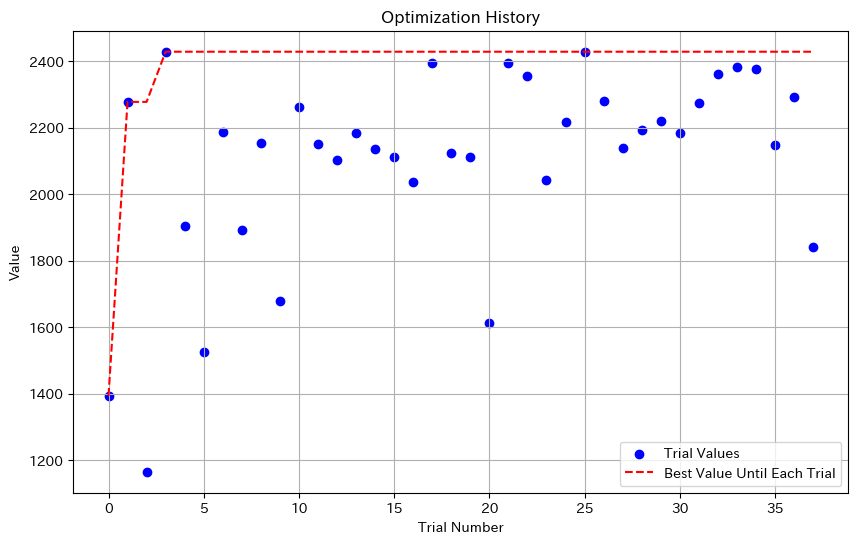

In [82]:
# シミュレーション結果を確認
# optuna.visualization.plot_optimization_history(study)


def custom_plot_optimization_history(study):
    # Extract trial numbers and values
    trials = study.trials_dataframe()
    trial_numbers = trials["number"]
    values = trials["value"]

    # Calculate the best value until each trial
    best_values = values.cummax()

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(trial_numbers, values, label="Trial Values", color="blue")

    # Plot the best values
    plt.plot(
        trial_numbers,
        best_values,
        color="red",
        linestyle="--",
        label="Best Value Until Each Trial",
    )

    # Add labels and title
    plt.xlabel("Trial Number")
    plt.ylabel("Value")
    plt.title("Optimization History")
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage
custom_plot_optimization_history(study)

### 6. `Sampler`を変更してみる

CMA-ES (一旦時間を倍にする)

In [39]:
%%time
dr.Client()
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, timeout=timeout*2, gc_after_trial=True)

[I 2025-02-24 20:44:23,150] A new study created in memory with name: no-name-930ed64d-0866-43cf-96ff-86ce970546fa
[I 2025-02-24 20:44:23,618] Trial 0 finished with value: 1772.6025390625 and parameters: {'炭素': 0.02, 'マンガン': 1.188, 'ケイ素': 1.1380000000000001, 'クロム': 17.668, 'ニッケル': 13.697999999999999, 'モリブデン': 9.586, 'バナジウム': 3.4, '窒素': 0.04, 'ニオブ': 0.78, 'コバルト': 3.678, 'タングステン': 6.23, 'アルミニウム': 1.6280000000000001, 'チタン': 1.18}. Best is trial 0 with value: 1772.6025390625.
[I 2025-02-24 20:44:24,154] Trial 1 finished with value: 1501.1370849609 and parameters: {'炭素': 0.21, 'マンガン': 1.508, 'ケイ素': 2.688, 'クロム': 8.367999999999999, 'ニッケル': 11.218, 'モリブデン': 9.336, 'バナジウム': 2.87, '窒素': 0.08, 'ニオブ': 2.06, 'コバルト': 17.018, 'タングステン': 4.32, 'アルミニウム': 0.10800000000000001, 'チタン': 0.54}. Best is trial 0 with value: 1772.6025390625.
[I 2025-02-24 20:44:24,681] Trial 2 finished with value: 2093.8693847656 and parameters: {'炭素': 0.34, 'マンガン': 2.918, 'ケイ素': 2.838, 'クロム': 7.748, 'ニッケル': 18.988, 'モリブデン': 5.0

CPU times: user 7.92 s, sys: 403 ms, total: 8.33 s
Wall time: 1min


In [40]:
print(study.best_trial.params)
print(study.best_trial.value)
print(study.best_trial.number)

{'炭素': 0.29, 'マンガン': 2.068, 'ケイ素': 4.538, 'クロム': 9.017999999999999, 'ニッケル': 17.067999999999998, 'モリブデン': 6.606, 'バナジウム': 2.08, '窒素': 0.07, 'ニオブ': 0.0, 'コバルト': 15.458, 'タングステン': 1.52, 'アルミニウム': 1.608, 'チタン': 1.5}
2407.1623535156
23


In [ ]:
# シミュレーション結果を確認
# optuna.visualization.plot_optimization_history(study)
custom_plot_optimization_history(study)

もしTPE Samplerの結果をベースにCMA-ESで最適化したら

In [42]:
%%time
# TPE Samplerの結果を既知の結果として投入
sampler = optuna.samplers.CmaEsSampler(seed=seed, source_trials=trails_bk)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, timeout=timeout, gc_after_trial=True)

[I 2025-02-24 20:45:23,310] A new study created in memory with name: no-name-b68ff769-939b-43ac-aef8-9db45ca1a924
[I 2025-02-24 20:45:23,852] Trial 0 finished with value: 1393.7081298828 and parameters: {'炭素': 0.09, 'マンガン': 1.3980000000000001, 'ケイ素': 4.748, 'クロム': 4.178, 'ニッケル': 23.098, 'モリブデン': 9.146, 'バナジウム': 3.75, '窒素': 0.18, 'ニオブ': 2.54, 'コバルト': 5.638, 'タングステン': 3.5500000000000003, 'アルミニウム': 1.548, 'チタン': 0.3}. Best is trial 0 with value: 1393.7081298828.
[I 2025-02-24 20:45:24,387] Trial 1 finished with value: 2145.5375976562 and parameters: {'炭素': 0.18, 'マンガン': 3.5380000000000003, 'ケイ素': 4.308, 'クロム': 6.378, 'ニッケル': 4.508, 'モリブデン': 4.976, 'バナジウム': 2.5300000000000002, '窒素': 0.06, 'ニオブ': 1.98, 'コバルト': 15.517999999999999, 'タングステン': 4.19, 'アルミニウム': 1.988, 'チタン': 2.59}. Best is trial 1 with value: 2145.5375976562.
[I 2025-02-24 20:45:24,859] Trial 2 finished with value: 2116.8862304688 and parameters: {'炭素': 0.42, 'マンガン': 2.708, 'ケイ素': 4.158, 'クロム': 9.607999999999999, 'ニッケル': 12.218, 

CPU times: user 4.2 s, sys: 187 ms, total: 4.39 s
Wall time: 30.2 s


In [ ]:
# シミュレーション結果を確認
# optuna.visualization.plot_optimization_history(study)
custom_plot_optimization_history(study)

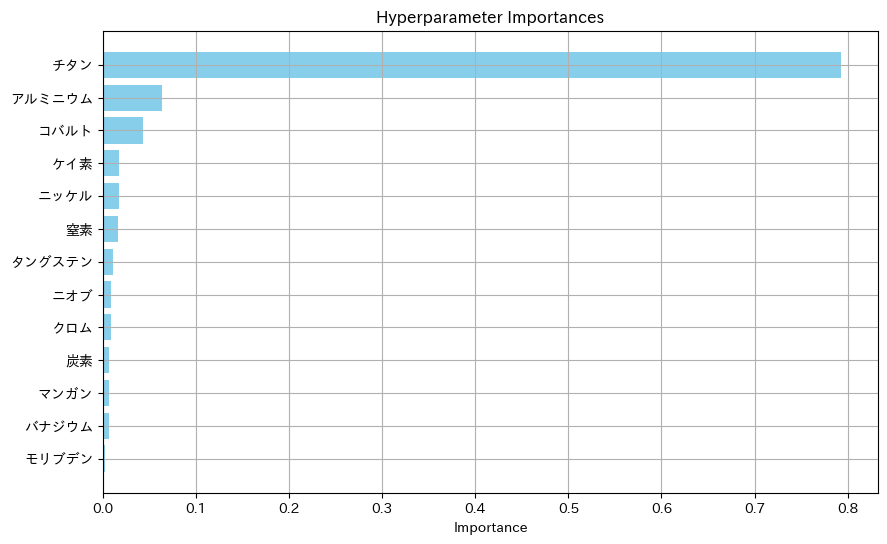

In [84]:
# どの変数が一番聞いているのかをみてみましょう
# optuna.visualization.plot_param_importances(study)
def custom_plot_param_importances(study):
    importances = optuna.importance.get_param_importances(study)
    params = list(importances.keys())
    values = list(importances.values())

    plt.figure(figsize=(10, 6))
    plt.barh(params, values, color="skyblue")
    plt.xlabel("Importance")
    plt.title("Hyperparameter Importances")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()


# Example usage
custom_plot_param_importances(study)

In [ ]:
# 上位３変数とターゲットの関係を可視化してみる
# optuna.visualization.plot_parallel_coordinate(
#     study, params=["ニオブ", "チタン", "コバルト"]
# )

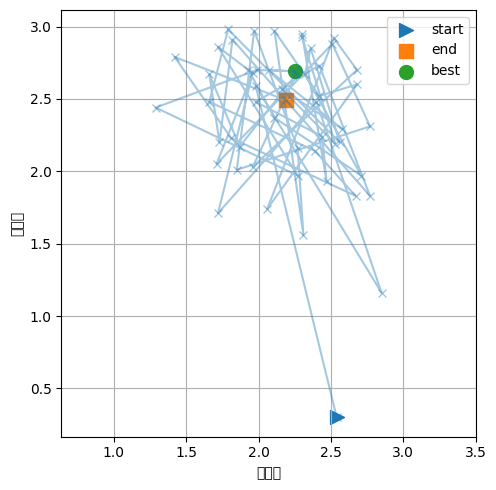

In [46]:
# 上位２変数の履歴を可視化してみる
# https://qiita.com/maskot1977/items/ed698a67b091b5516ab4
x = "ニオブ"
y = "チタン"
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(
    [trial.params[x] for trial in study.trials],
    [trial.params[y] for trial in study.trials],
    alpha=0.4,
    marker="x",
)
ax.scatter(
    study.trials[0].params[x],
    study.trials[0].params[y],
    marker=">",
    label="start",
    s=100,
)
ax.scatter(
    study.trials[-1].params[x],
    study.trials[-1].params[y],
    marker="s",
    label="end",
    s=100,
)
ax.scatter(study.best_params[x], study.best_params[y], marker="o", label="best", s=100)

ax.axis("equal")
ax.set_xlabel(x)
ax.set_ylabel(y)
fig.tight_layout()
plt.grid()
plt.legend()
plt.show()

### 7. `Pruner`も変更してみる

In [47]:
# 打ち止めするかを確認するため、途中経過をフィードバックするようにobjectiveを編集
n_train_iter = 10


def objective(trial):

    df_target = DataFrame(index=[0], columns=X_train.columns)

    for col in X_train.columns:
        low = stat.loc[col, "min"] * 0.8
        high = stat.loc[col, "max"] * 1.2
        df_target[col] = trial.suggest_float(col, low, high, step=0.01)

    for step in range(n_train_iter):
        pred_1 = predict(deployments[0], df_target)[0].loc[0, "降伏強度_PREDICTION"]

        # 打ち止めかどうかを判断
        pred_temp = pred_1

        trial.report(pred_temp, step)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return pred_1

In [48]:
%%time
# 打ち切りしているため、トライごとの時間がかかる
# 試行回数が減るため効果が出にくい
dr.Client()
sampler = optuna.samplers.TPESampler(seed=seed)
pruner = optuna.pruners.HyperbandPruner(min_resource=1, max_resource=n_train_iter)
study = optuna.create_study(direction="maximize",sampler=sampler, pruner=pruner)
study.optimize(objective, timeout=timeout, gc_after_trial=True)

[I 2025-02-24 20:45:54,836] A new study created in memory with name: no-name-f55df53f-11ee-4e81-b31e-61e3cff12acc
[I 2025-02-24 20:45:59,361] Trial 0 finished with value: 1393.7081298828 and parameters: {'炭素': 0.09, 'マンガン': 1.3980000000000001, 'ケイ素': 4.748, 'クロム': 4.178, 'ニッケル': 23.098, 'モリブデン': 9.146, 'バナジウム': 3.75, '窒素': 0.18, 'ニオブ': 2.54, 'コバルト': 5.638, 'タングステン': 3.5500000000000003, 'アルミニウム': 1.548, 'チタン': 0.3}. Best is trial 0 with value: 1393.7081298828.
[I 2025-02-24 20:46:03,970] Trial 1 finished with value: 2278.1721191406 and parameters: {'炭素': 0.31, 'マンガン': 0.498, 'ケイ素': 5.128, 'クロム': 5.168, 'ニッケル': 24.038, 'モリブデン': 9.146, 'バナジウム': 2.25, '窒素': 0.04, 'ニオブ': 1.11, 'コバルト': 13.738, 'タングステン': 3.16, 'アルミニウム': 1.858, 'チタン': 2.7800000000000002}. Best is trial 1 with value: 2278.1721191406.
[I 2025-02-24 20:46:08,523] Trial 2 finished with value: 1164.8432617188 and parameters: {'炭素': 0.01, 'マンガン': 1.168, 'ケイ素': 1.928, 'クロム': 13.168, 'ニッケル': 1.9080000000000001, 'モリブデン': 2.636, 'バナジウム'

CPU times: user 1.79 s, sys: 228 ms, total: 2.01 s
Wall time: 34.5 s


In [ ]:
%%time
# 並列数を増やして、時間内のトライアル数を増やす
dr.Client()
sampler = optuna.samplers.TPESampler(seed=seed)
pruner = optuna.pruners.HyperbandPruner(min_resource=1, max_resource=n_train_iter)
study = optuna.create_study(direction="maximize",sampler=sampler, pruner=pruner)
study.optimize(objective, timeout=timeout, gc_after_trial=True, n_jobs=2)

[I 2025-02-24 20:46:29,416] A new study created in memory with name: no-name-6b8e3da9-268f-4b8c-b732-966131a96dac
[I 2025-02-24 20:46:35,279] Trial 3 finished with value: 1254.4832763672 and parameters: {'炭素': 0.17, 'マンガン': 1.6380000000000001, 'ケイ素': 0.468, 'クロム': 4.078, 'ニッケル': 12.418, 'モリブデン': 1.316, 'バナジウム': 2.34, '窒素': 0.03, 'ニオブ': 1.9000000000000001, 'コバルト': 4.298, 'タングステン': 7.1000000000000005, 'アルミニウム': 0.07800000000000001, 'チタン': 0.47000000000000003}. Best is trial 3 with value: 1254.4832763672.
[I 2025-02-24 20:46:36,175] Trial 2 finished with value: 2308.1611328125 and parameters: {'炭素': 0.49, 'マンガン': 1.278, 'ケイ素': 2.938, 'クロム': 5.8180000000000005, 'ニッケル': 15.158, 'モリブデン': 4.096, 'バナジウム': 1.3800000000000001, '窒素': 0.11, 'ニオブ': 2.72, 'コバルト': 11.988, 'タングステン': 6.2, 'アルミニウム': 1.948, 'チタン': 2.8000000000000003}. Best is trial 2 with value: 2308.1611328125.
[I 2025-02-24 20:46:36,242] Trial 0 finished with value: 1925.1541748047 and parameters: {'炭素': 0.44, 'マンガン': 1.868, 'ケイ素': 4.5

CPU times: user 3.39 s, sys: 272 ms, total: 3.66 s
Wall time: 34.7 s


In [50]:
print(study.best_trial.params)
print(study.best_trial.value)
print(study.best_trial.number)

{'炭素': 0.51, 'マンガン': 0.138, 'ケイ素': 3.938, 'クロム': 13.517999999999999, 'ニッケル': 17.258, 'モリブデン': 3.176, 'バナジウム': 1.43, '窒素': 0.17, 'ニオブ': 1.18, 'コバルト': 19.578, 'タングステン': 8.0, 'アルミニウム': 1.558, 'チタン': 1.2}
2327.5334472656
17


In [ ]:
# シミュレーション結果を確認
# optuna.visualization.plot_optimization_history(study)
custom_plot_optimization_history(study)

### 8.不確実性を確認

In [68]:
# 最適化と同時に分位点予測も行う


def objective(trial):

    df_target = DataFrame(index=[0], columns=X_train.columns)
    for col in X_train.columns:
        low = stat.loc[col, "min"] * 0.8
        high = stat.loc[col, "max"] * 1.2
        df_target[col] = trial.suggest_float(col, low, high, step=0.01)

    pred_2 = predict(deployments[0], df_target)[0].loc[0, "降伏強度_PREDICTION"]
    pred_p25 = predict(deployments_quant[0], df_target)[0].loc[0, "降伏強度_PREDICTION"]
    pred_p75 = predict(deployments_quant[1], df_target)[0].loc[0, "降伏強度_PREDICTION"]

    trial.set_user_attr("p25", pred_p25)
    trial.set_user_attr("p75", pred_p75)

    return pred_2

In [71]:
%%time
dr.Client()
sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(sampler=sampler,direction="maximize")
study.optimize(objective, timeout=timeout*2, gc_after_trial=True)

[I 2025-02-24 21:58:57,134] A new study created in memory with name: no-name-5d19d2ee-6c5e-4d37-95b4-1fbca251839a
[I 2025-02-24 21:58:59,001] Trial 0 finished with value: 1393.7081298828 and parameters: {'炭素': 0.09, 'マンガン': 1.3980000000000001, 'ケイ素': 4.748, 'クロム': 4.178, 'ニッケル': 23.098, 'モリブデン': 9.146, 'バナジウム': 3.75, '窒素': 0.18, 'ニオブ': 2.54, 'コバルト': 5.638, 'タングステン': 3.5500000000000003, 'アルミニウム': 1.548, 'チタン': 0.3}. Best is trial 0 with value: 1393.7081298828.
[I 2025-02-24 21:59:00,722] Trial 1 finished with value: 2278.1721191406 and parameters: {'炭素': 0.31, 'マンガン': 0.498, 'ケイ素': 5.128, 'クロム': 5.168, 'ニッケル': 24.038, 'モリブデン': 9.146, 'バナジウム': 2.25, '窒素': 0.04, 'ニオブ': 1.11, 'コバルト': 13.738, 'タングステン': 3.16, 'アルミニウム': 1.858, 'チタン': 2.7800000000000002}. Best is trial 1 with value: 2278.1721191406.
[I 2025-02-24 21:59:02,205] Trial 2 finished with value: 1164.8432617188 and parameters: {'炭素': 0.01, 'マンガン': 1.168, 'ケイ素': 1.928, 'クロム': 13.168, 'ニッケル': 1.9080000000000001, 'モリブデン': 2.636, 'バナジウム'

CPU times: user 5.19 s, sys: 348 ms, total: 5.54 s
Wall time: 1min 2s


In [72]:
df_trials = study.trials_dataframe()
df_trials.head()

,number,value,datetime_start,datetime_complete,duration,params_アルミニウム,params_クロム,params_ケイ素,params_コバルト,params_タングステン,params_チタン,params_ニオブ,params_ニッケル,params_バナジウム,params_マンガン,params_モリブデン,params_炭素,params_窒素,user_attrs_p25,user_attrs_p75,state
0,0,1393.70812988,2025-02-24 21:58:57.135127,2025-02-24 21:58:59.001123,0 days 00:00:01.865996,1.548,4.178,4.748,5.638,3.55,0.30,2.54,23.098,3.75,1.398,9.146,0.09,0.18,1333.57935078,1185.86526778,COMPLETE
1,1,2278.17211914,2025-02-24 21:58:59.145813,2025-02-24 21:59:00.722616,0 days 00:00:01.576803,1.858,5.168,5.128,13.738,3.16,2.78,1.11,24.038,2.25,0.498,9.146,0.31,0.04,2303.98973463,1951.07504225,COMPLETE
2,2,1164.84326172,2025-02-24 21:59:00.799099,2025-02-24 21:59:02.205684,0 days 00:00:01.406585,0.398,13.168,1.928,7.018,2.60,0.41,2.63,1.908,4.77,1.168,2.636,0.01,0.04,1291.33436663,1179.43604161,COMPLETE
3,3,2429.18945312,2025-02-24 21:59:02.285660,2025-02-24 21:59:03.793798,0 days 00:00:01.508138,1.538,6.508,4.378,18.618,4.79,2.10,1.70,17.518,2.74,2.638,11.016,0.25,0.07,2264.60268636,1875.20093591,COMPLETE
4,4,1905.27661133,2025-02-24 21:59:03.868300,2025-02-24 21:59:05.251339,0 days 00:00:01.383039,0.318,11.568,4.888,14.808,2.45,1.35,0.80,1.998,1.31,0.048,6.256,0.08,0.18,1818.22945943,1584.41286344,COMPLETE


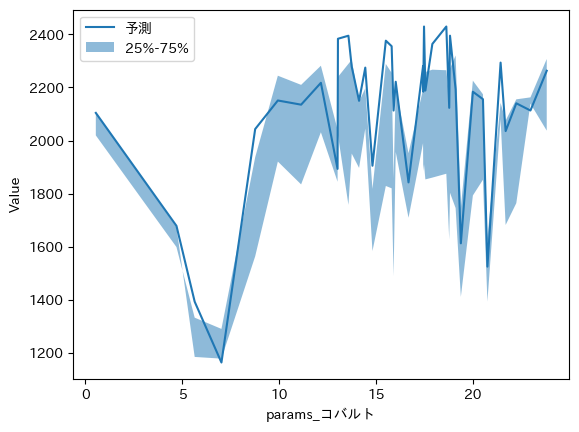

In [80]:
import matplotlib.pyplot as plt

# Extract columns with 'params_' prefix
params_columns = ["number"] + [
    col for col in df_trials.columns if col.startswith("params_")
]


# Function to plot the selected column
def plot_selected_column(column):
    _df = df_trials.sort_values(column)
    fig, ax = plt.subplots()
    ax.plot(_df[column], _df["value"], label="予測")
    ax.fill_between(
        _df[column],
        _df["user_attrs_p25"],
        _df["user_attrs_p75"],
        alpha=0.5,
        label="25%-75%",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Value")
    ax.legend()
    plt.show()


# Example usage: plot the first parameter column
plot_selected_column(params_columns[4])

In [52]:
# This is the end of this code...